In [1]:
# Importing all the dough
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings

# Pretty looking cofigs
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("./data/data.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data = data.set_index('Date')
data.head(7)

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
Date,,,,,,
2011-01-03,6177.45,6178.55,6147.20,6157.60,96028639,4477.36
2011-01-04,6172.75,6181.05,6124.40,6146.35,181727905,7678.55
2011-01-05,6141.35,6141.35,6062.35,6079.80,139614193,6606.21
2011-01-06,6107.00,6116.15,6022.30,6048.25,152338978,7050.18
2011-01-07,6030.90,6051.20,5883.60,5904.60,171809106,8325.79
2011-01-10,5901.30,5907.25,5740.95,5762.85,156945855,7920.38
2011-01-11,5767.95,5842.60,5698.20,5754.10,161261704,8307.22


In [4]:
data.describe()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
count,2621.000000,2621.000000,2621.000000,2621.000000,2.621000e+03,2621.000000
mean,8697.276116,8741.203243,8637.318714,8689.678462,2.747532e+08,12811.626944
std,2732.034119,2739.781369,2715.124602,2728.318740,2.022228e+08,9723.911242
min,4623.150000,4623.150000,4531.150000,4544.200000,6.555703e+06,297.890000
25%,6018.850000,6050.500000,5977.150000,6007.450000,1.473129e+08,6422.970000
50%,8406.500000,8455.650000,8355.400000,8398.300000,1.932502e+08,8717.160000
75%,10746.800000,10786.050000,10689.700000,10739.950000,3.202500e+08,15967.910000
max,15958.350000,15962.250000,15882.600000,15924.200000,1.811564e+09,78522.930000


In [5]:
data.shape

(2621, 6)

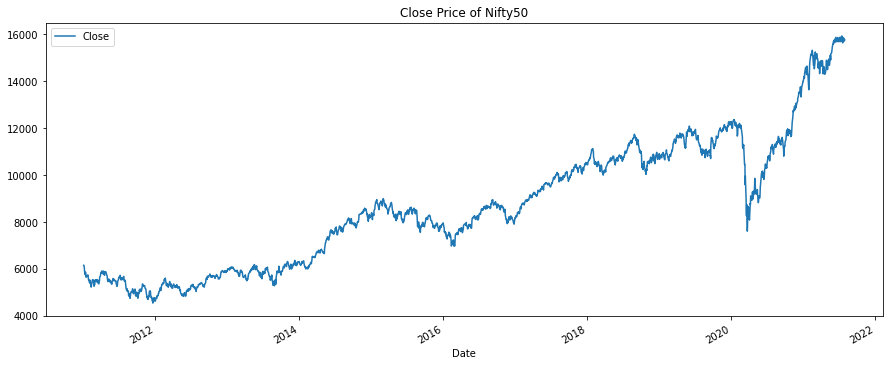

In [8]:
data.plot(y=['Close'], figsize=(15, 6))
plt.legend(loc='best')
plt.title('Close Price of Nifty50')
plt.show(block=False)

### Train-test split

In [17]:
train_len = 2100
train = data[0:train_len] # first 2100 days as training set
test = data[train_len:] # last remaining as out-of-time test set

### Holt-Winters Additive w/ Trend & Seasonality

Model

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(521)

{'smoothing_level': 0.7993535173659982, 'smoothing_trend': 0.026444577163963562, 'smoothing_seasonal': 0.1670883199545391, 'damping_trend': nan, 'initial_level': 7822.824220276485, 'initial_trend': -23.223661054437486, 'initial_seasons': array([-1833.00441012, -1850.95340764, -1867.76906531, -1854.65028524,
       -1877.80215138, -1913.11177717, -1933.55111968, -1895.06718301,
       -1923.3864457 , -1955.97568397, -1943.36452531, -1948.40231412]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Plot and Forecast

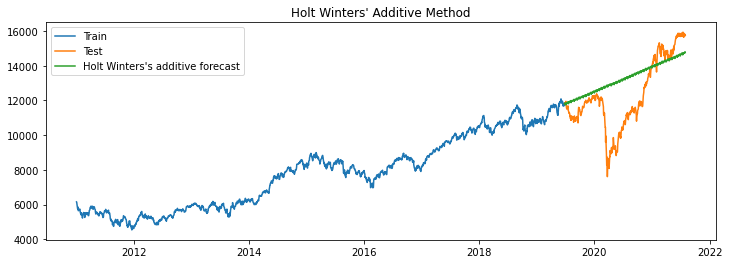

In [20]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Holt-Winters Multiplicative w/ Trend & Seasonality

Model

In [21]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(521)

{'smoothing_level': 0.8182142857142858, 'smoothing_trend': 0.031469780219780225, 'smoothing_seasonal': 0.16663690476190468, 'damping_trend': nan, 'initial_level': 7778.608000000001, 'initial_trend': -24.84861111111113, 'initial_seasons': array([0.79160693, 0.79016066, 0.78160514, 0.77754915, 0.75908183,
       0.74085878, 0.7397339 , 0.75376597, 0.73945107, 0.72693598,
       0.72696169, 0.73587074]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


Plot and Forecast

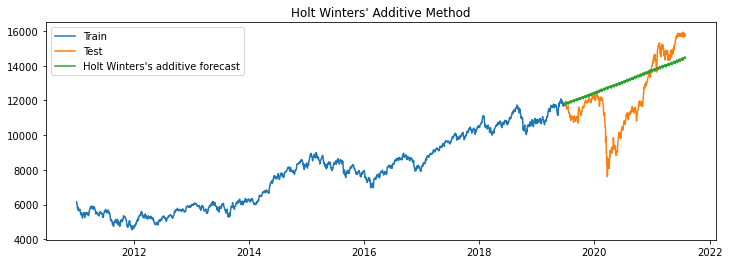

In [22]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Box-Cox

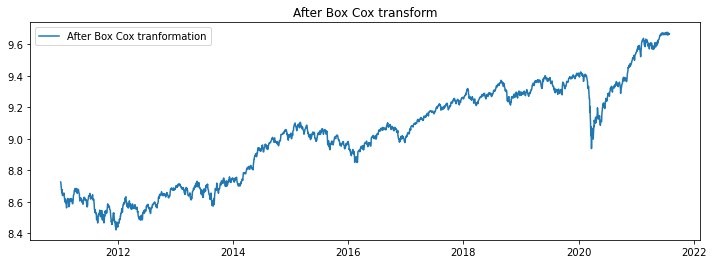

In [23]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Close'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing

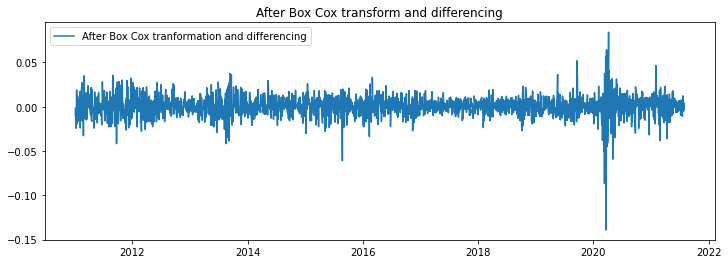

In [24]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [25]:
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff.tail()

Date
2021-07-26   -0.001995
2021-07-27   -0.004941
2021-07-28   -0.002356
2021-07-29    0.004386
2021-07-30   -0.000976
dtype: float64

In [26]:
# Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -14.323649
Critical Values @ 0.05: -2.86
p-value: 0.000000


In [28]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.116436
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\Harshal\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


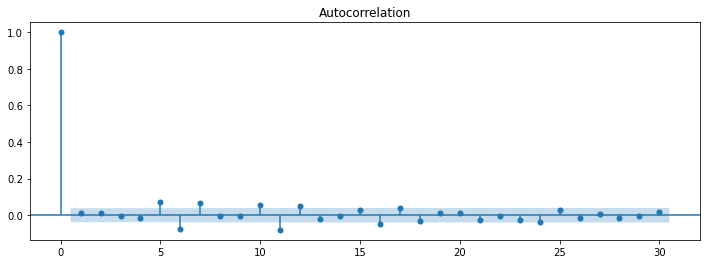

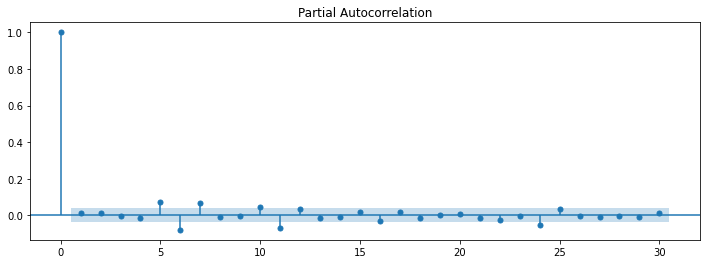

In [29]:
# Autocorrelation and Partial-Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

In [30]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### SARIMA

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\Harshal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Harshal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Harshal\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1      -0.047469
ma.L1       0.128102
ar.S.L12    0.021876
ma.S.L12   -0.998243
sigma2      0.000092
dtype: float64


In [32]:
# Recover original series
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'